# Tâche 7

In [95]:
from pymatgen.ext.matproj import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants
import copy
mp_id = "mp-22660"
with MPRester("MVjrPtjUJ4K2IdZ4zJmL2QqGBqEUCt6C") as m:
    structure = m.get_bandstructure_by_material_id(mp_id)

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [96]:
from pymatgen.core.structure import Structure
from jupyter_jsmol.pymatgen import quick_view
from pymatgen.electronic_structure import bandstructure
from pymatgen.electronic_structure import plotter
from pymatgen.phonon.plotter import PhononBSPlotter
from pymatgen.electronic_structure.core import Spin

## Visualisation de la structure de bandes électroniques

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

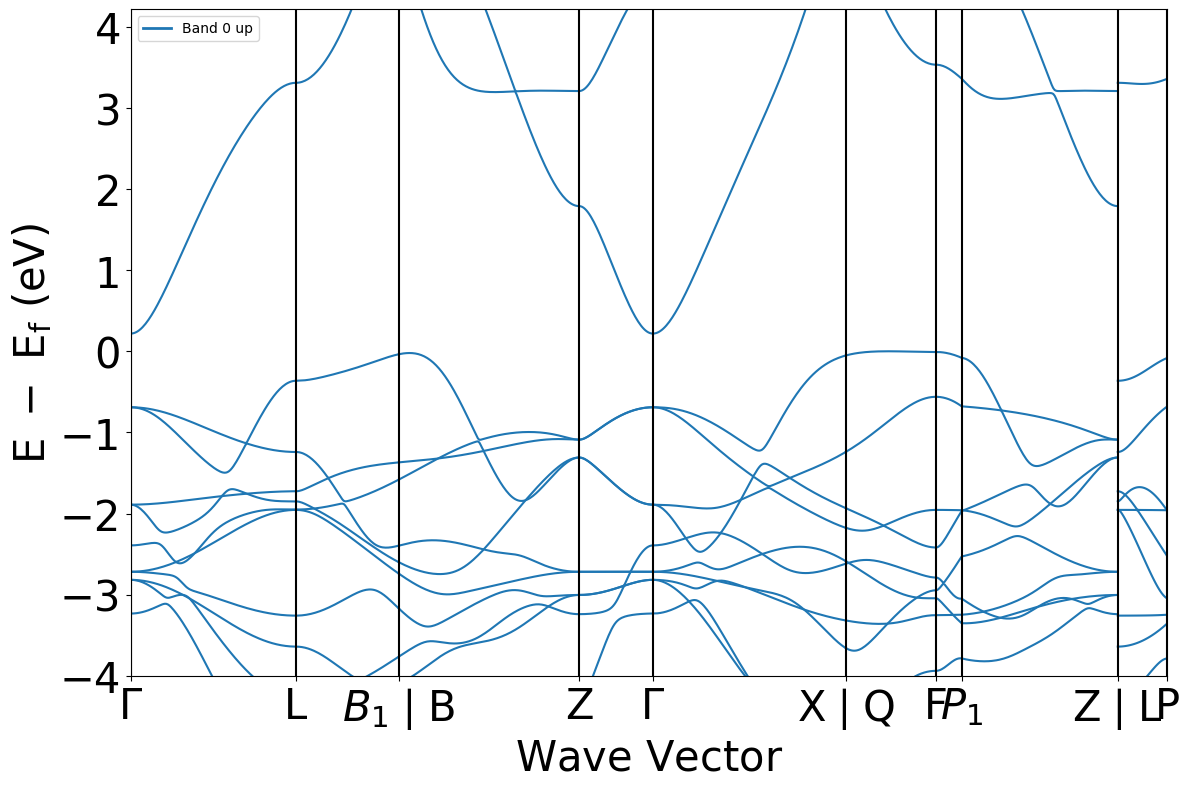

In [97]:
el_bs = m.get_bandstructure_by_material_id(mp_id) #Bandes électroniques
el_dos = m.get_dos_by_material_id(mp_id) #Densité électronique
plot_el_bs = BSPlotter(el_bs)
plot_el_bs.show()

# Bande interdite 

In [98]:
gap = el_bs.get_band_gap()
print(gap)
gap = structure.get_band_gap()
if gap.get('direct') == False:
    print('La bande interdite est indirecte.')
else:
    print('La bande interdite est directe.')
print("La bande interdite s'étend sur {}".format(gap.get('energy'))+"eV dans la direction {}.".format(gap['transition']))

{'direct': False, 'energy': 0.21829999999999972, 'transition': '(0.586,0.414,-0.000)-\\Gamma'}
La bande interdite est indirecte.
La bande interdite s'étend sur 0.21829999999999972eV dans la direction (0.586,0.414,-0.000)-\Gamma.


Même résultat que sur Materials Project !

Comme la bande interdite est indirecte, la transition d'un électron de la BV à la BC nécessite non seulement un apport d'énergie mais aussi un changement de vecteur d'onde. 
L'énergie minimal à fournir à un électron pour passer de la dernière bande de valence à la première bande de conduction est de 0.2183 [eV]. 
On observe que cette énergie est assez faible et inférieur à 1 [eV], la matériau est donc considéré comme semi-conducteur.

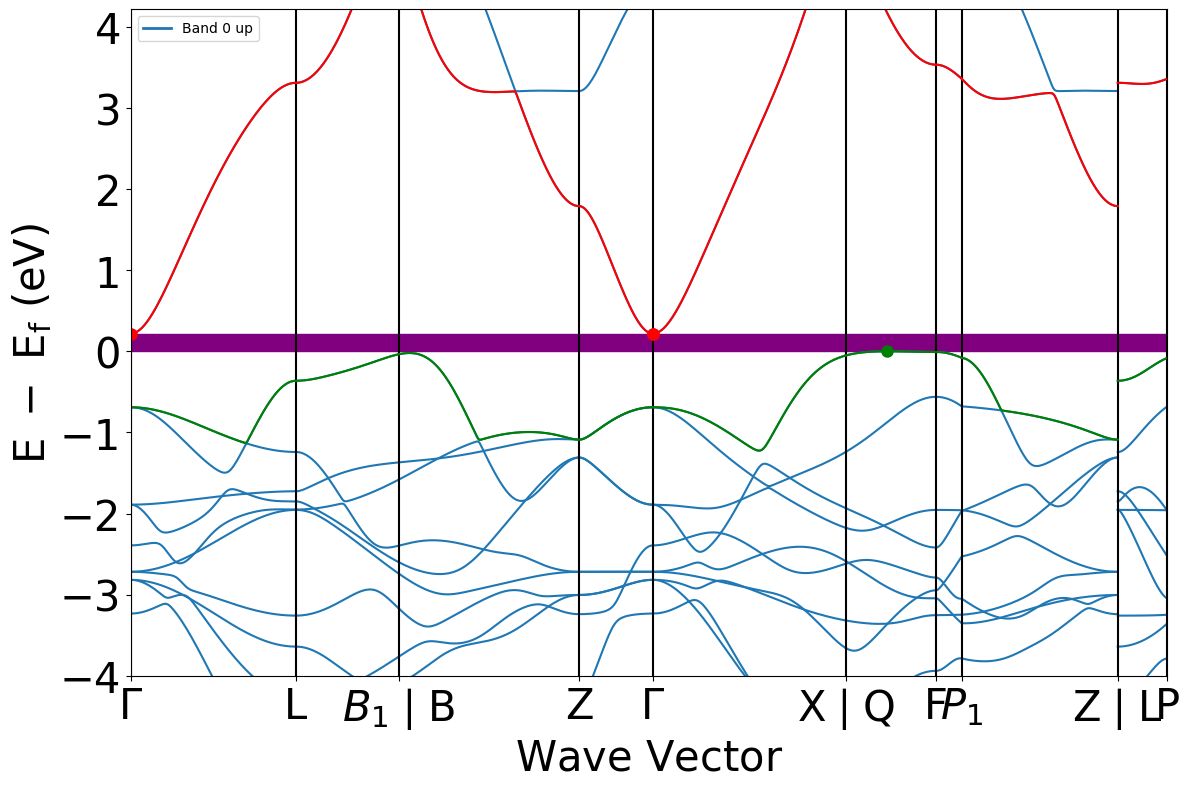

In [99]:
bs_plot_data = BSPlotter(el_bs).bs_plot_data()
distance = bs_plot_data.get('ticks').get('distance')
distances = bs_plot_data.get('distances')
energy = bs_plot_data.get('energy')


vbm_band_index = el_bs.get_vbm()['band_index'][Spin.up][-1]  # Dernière bande de valence
cbm_band_index = el_bs.get_cbm()['band_index'][Spin.up][0]   # Première bande de conduction


BSPlotter(el_bs).get_plot()


for i in range(len(distances)):
    plt.plot(distances[i], energy.get('1')[i][vbm_band_index], 'green') 
    plt.plot(distances[i], energy.get('1')[i][cbm_band_index], 'red') 
    
vbm_coord = bs_plot_data.get('vbm')
for (x, y) in vbm_coord:
    plt.plot(x, y, 'og', markersize=8) 


cbm_coord = bs_plot_data.get('cbm')
for (x, y) in cbm_coord:
    plt.plot(x, y, 'or', markersize=8)  
 

plt.fill_between(np.linspace(distance[0], distance[-1], 500), 0, el_bs.get_band_gap().get('energy'), color="purple")

plt.show()

In [100]:
print("Bande de valence de plus haute énergie: ", structure.get_vbm()['band_index'],'\n')
print("Bande de conduction de plus basse énergie: ", structure.get_cbm()['band_index'],'\n')

Bande de valence de plus haute énergie:  defaultdict(<class 'list'>, {<Spin.up: 1>: [17]}) 

Bande de conduction de plus basse énergie:  defaultdict(<class 'list'>, {<Spin.up: 1>: [18]}) 



In [101]:
bsplot = BSPlotter(el_bs)
bsdata = bsplot.bs_plot_data()

vbm = el_bs.get_vbm()
indices_vbm = list(vbm["band_index"].get(Spin.up, [])) 
kpoint_vbm = vbm["kpoint"].cart_coords

print("\nDernière bande de valence :")
print("Énergie du maximum de la bande de valence = {:.2f} eV".format(vbm["energy"]))
print("Vecteur k en coordonnées cartésiennes =", kpoint_vbm)
print("Indices des bandes de valence :", indices_vbm)

cbm = el_bs.get_cbm()
indices_cbm = list(cbm["band_index"].get(Spin.up, [])) 
kpoint_cbm = cbm["kpoint"].cart_coords

print("\nPremière bande de conduction :")
print("Énergie minimum de la bande de conduction = {:.2f} eV".format(cbm["energy"]))
print("Vecteur k en coordonnées cartésiennes =", kpoint_cbm)
print("Indices des bandes de conduction :", indices_cbm)


Dernière bande de valence :
Énergie du maximum de la bande de valence = 3.40 eV
Vecteur k en coordonnées cartésiennes = [ 0.48532822 -0.32460463 -1.02773377]
Indices des bandes de valence : [17]

Première bande de conduction :
Énergie minimum de la bande de conduction = 3.62 eV
Vecteur k en coordonnées cartésiennes = [0. 0. 0.]
Indices des bandes de conduction : [18]


# Directions des dispersions minimales et maximales

On cherche à déterminer les directions pour lesquelles la dispersion est minimale/maximale pour ces bandes de valence et de conduction. La dispersion sur un chemin quelconque x-y est la pente du vecteur qui relie, sur le diagramme, les valeurs énergétique correspondantes en x et y. Par conséquent, pour trouver la dispersion maximale (minimale) pour chaque bande, il suffit de trouver le chemin ayant la plus grande (petite) pente. 

In [102]:
x = np.unique(bsdata["ticks"]["distance"])  
y = bsdata["energy"]

num_points = len(x) - 1 

dx = np.zeros(num_points)
dy_vbm = np.zeros(num_points)
dy_cbm = np.zeros(num_points)
m_vbm = np.zeros(num_points)
m_cbm = np.zeros(num_points)

for i in range(num_points):
    dx[i] = x[i+1] - x[i]

for i in range(num_points):
    dy_vbm[i] = y["1"][i][17][-1] - y["1"][i][17][0] 
    dy_cbm[i] = y["1"][i][18][-1] - y["1"][i][18][0] 


for i in range(num_points):
    m_vbm[i] = dy_vbm[i] / dx[i]
    m_cbm[i] = dy_cbm[i] / dx[i]

idx_max_vbm = np.argmax(abs(m_vbm))
idx_min_vbm = np.argmin(abs(m_vbm))
idx_max_cbm = np.argmax(abs(m_cbm))
idx_min_cbm = np.argmin(abs(m_cbm))

print("En valeur absolue :")
print("La plus grande dispersion pour la bande de valence : {:.6f} (index {})".format(abs(m_vbm[idx_max_vbm]), idx_max_vbm))
print("La plus grande dispersion pour la bande de conduction : {:.6f} (index {})".format(abs(m_cbm[idx_max_cbm]), idx_max_cbm))
print("La plus faible dispersion pour la bande de valence : {:.6f} (index {})".format(abs(m_vbm[idx_min_vbm]), idx_min_vbm))
print("La plus faible dispersion pour la bande de conduction : {:.6f} (index {})".format(abs(m_cbm[idx_min_cbm]), idx_min_cbm))

En valeur absolue :
La plus grande dispersion pour la bande de valence : 0.970290 (index 7)
La plus grande dispersion pour la bande de conduction : 4.088845 (index 4)
La plus faible dispersion pour la bande de valence : 0.071663 (index 5)
La plus faible dispersion pour la bande de conduction : 0.155050 (index 8)


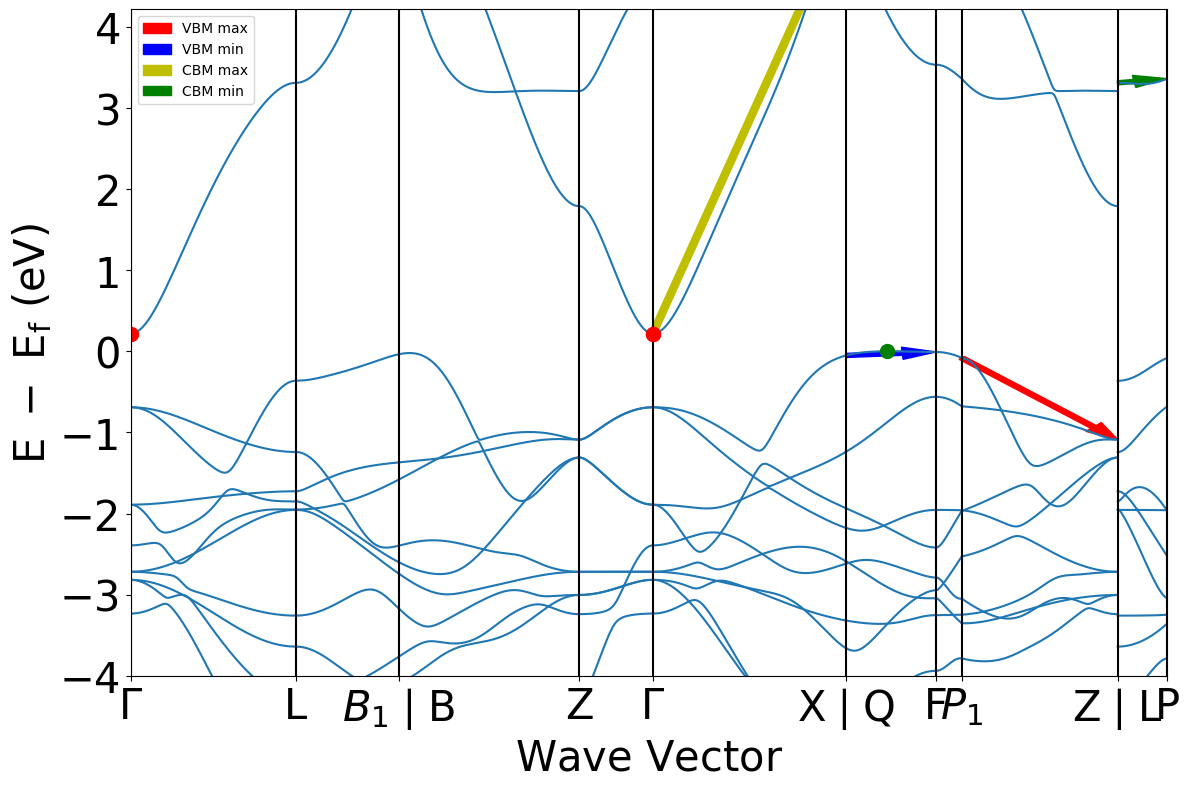

In [103]:
bsplot.get_plot()


plt.arrow(x[idx_max_vbm], y["1"][idx_max_vbm][17][0], dx[idx_max_vbm], dy_vbm[idx_max_vbm], 
          color='r', width=0.05, head_width=0.15, length_includes_head=True, label="VBM max")

plt.arrow(x[idx_min_vbm], y["1"][idx_min_vbm][17][0], dx[idx_min_vbm], dy_vbm[idx_min_vbm], 
          color='b', width=0.05, head_width=0.15, length_includes_head=True, label="VBM min") 

plt.arrow(x[idx_max_cbm], y["1"][idx_max_cbm][18][0], dx[idx_max_cbm], dy_cbm[idx_max_cbm], 
          color='y', width=0.05, head_width=0.15, length_includes_head=True, label="CBM max")

plt.arrow(x[idx_min_cbm], y["1"][idx_min_cbm][18][0], dx[idx_min_cbm], dy_cbm[idx_min_cbm], 
          color='g', width=0.05, head_width=0.15, length_includes_head=True, label="CBM min")


for (x, y) in bs_plot_data.get("vbm"):
    plt.plot(x, y, 'og', markersize=10)  

for (x, y) in bs_plot_data.get("cbm"):
    plt.plot(x, y, 'or', markersize=10) 

plt.legend()
plt.show()

La direction de la dernière bande de valence présentant le plus de dispersion (en rouge ci-dessus) est la direction : $P_1$-Z$\mid$L.
Celle présentant le moins de dispersion (en bleu ci-dessus) est la direction : X$\mid$Q-F.
La direction de la première bande de conduction présentant le plus de dispersion (en jaune ci-dessus) est la direction : \Rho-X$\mid$Q.
Celle présentant le moins de dispersion (en vert ci-dessus) est la direction : Z$\mid$L-P.

# Masse effective

En supposant une dispertion parabolique, la relation de dispertion entre l'énergie et le vecteur d'onde est: $E(k) = \frac{p^2}{2m} = \frac{\hbar^2k^2}{2m} = \frac{\hbar^2(k_x^2 + k_y^2 + k_z^2)}{2m}$ avec m la masse effective. Donc: $m = \frac{\hbar^2(k_x^2 + k_y^2 + k_z^2)}{2E(k)}$. Il ne reste plus qu'a récupérer le vecteur d'onde et l'énergie associés à ce sommet .

In [104]:
hbar = 1.0545718e-34
eV = 1.602176634e-19

val_k = vbm['kpoint'].frac_coords
val_k_norm = np.linalg.norm(val_k) / 1e-10
val_energy_J = abs(vbm["energy"]) * eV
m_vbm = (hbar**2 * val_k_norm**2) / (2 * val_energy_J)
print("La masse effective au sommet de la dernière bande de valence est {:.2e} kg.".format(m_vbm))

cond_k = cbm['kpoint'].frac_coords
cond_k_norm = np.linalg.norm(cond_k) / 1e-10 
cond_energy_J = abs(cbm["energy"]) * eV
m_cbm = (hbar**2 * cond_k_norm**2) / (2 * cond_energy_J)
print("La masse effective à la base de la première bande de conduction est {:.2e} kg.".format(m_cbm))

La masse effective au sommet de la dernière bande de valence est 5.25e-31 kg.
La masse effective à la base de la première bande de conduction est 0.00e+00 kg.
